utilizando a biblioteca mlforecast (https://nixtlaverse.nixtla.io/mlforecast/index.html), desenvolver uma previsão da produção de energia nuclear nos Estados Unidos, utlizando os modelos:
- Naive
- LinearRegression
- MLPRegressor
- KNeighborsRegressor
- XGBRegressor

### Instalação da biblioteca  

In [1]:
!pip install mlforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 583.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


### Importação das bibliotecas nescessarias

In [3]:
from utilsforecast.plotting import plot_series

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from xgboost import XGBRegressor
import lightgbm as lgb
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from statsmodels.tsa.stattools import adfuller

### Fazendo a carga dos dados, dividindo em teste e treino e fazendo a analise dos dados

In [4]:
dados = pd.read_csv('/content/electricity_Consumption_Productioction.csv')
dados.head()

,Date,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01,5957.666667,5924.416667,1391.750000,343.583333,1285.875000,1418.000000,1408.708333,43.291667,32.791667
1,2019-01-02,6322.041667,6795.708333,1390.833333,1106.750000,1252.708333,1615.166667,1340.625000,53.333333,35.750000
2,2019-01-03,7254.083333,7202.250000,1372.041667,989.291667,1477.208333,1822.166667,1467.708333,33.333333,39.833333
3,2019-01-04,7635.083333,7988.500000,1371.416667,1854.583333,1411.833333,1742.000000,1519.541667,45.500000,43.250000
4,2019-01-05,7379.750000,6836.208333,1393.333333,629.500000,1212.041667,1839.916667,1626.291667,92.750000,42.000000


In [8]:
df = pd.DataFrame({
    'unique_id': '0',
    'ds': dados['Date'],
    'y': dados['Nuclear']
})

In [9]:
df['ds'] = pd.to_datetime(df['ds'])

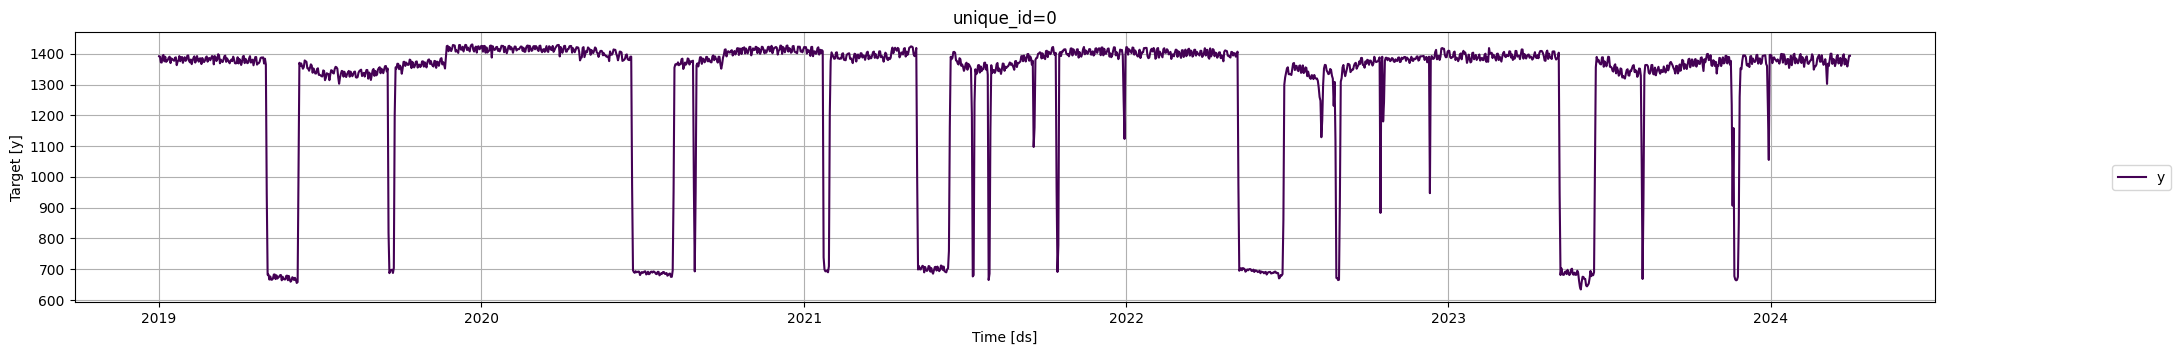

In [7]:
fig = plot_series(df)
fig

In [ ]:
df['unique_id'].value_counts()

unique_id
0    1917
Name: count, dtype: int64

In [ ]:
df_test = df.groupby('unique_id').tail(50)
df_train = df.drop(df_test.index)

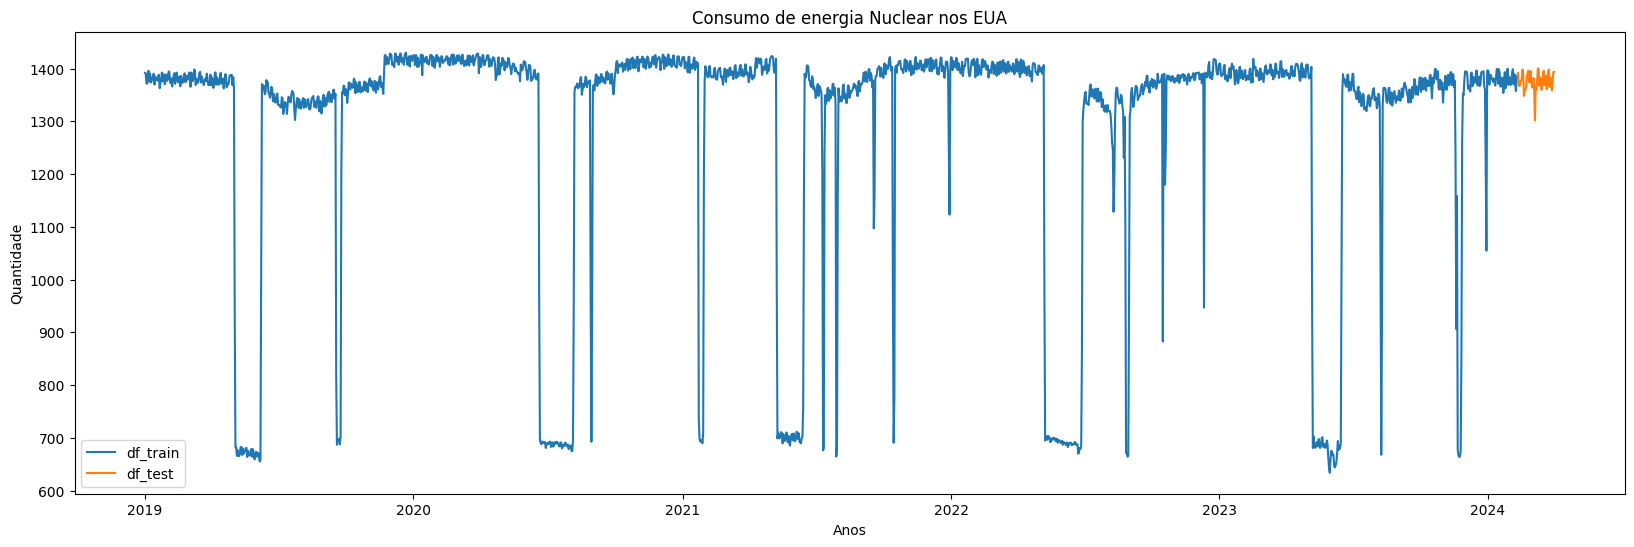

In [ ]:
plt.figure(figsize=(20, 6))

plt.title("Consumo de energia Nuclear nos EUA")
plt.plot(df_train['ds'], df_train['y'], label="df_train")
plt.plot(df_test['ds'], df_test['y'], label="df_test")
plt.xlabel("Anos")
plt.ylabel("Quantidade")
plt.legend(loc="best")
plt.show()

In [ ]:
df_test.shape

(50, 3)

In [ ]:
df_train.shape

(1867, 3)

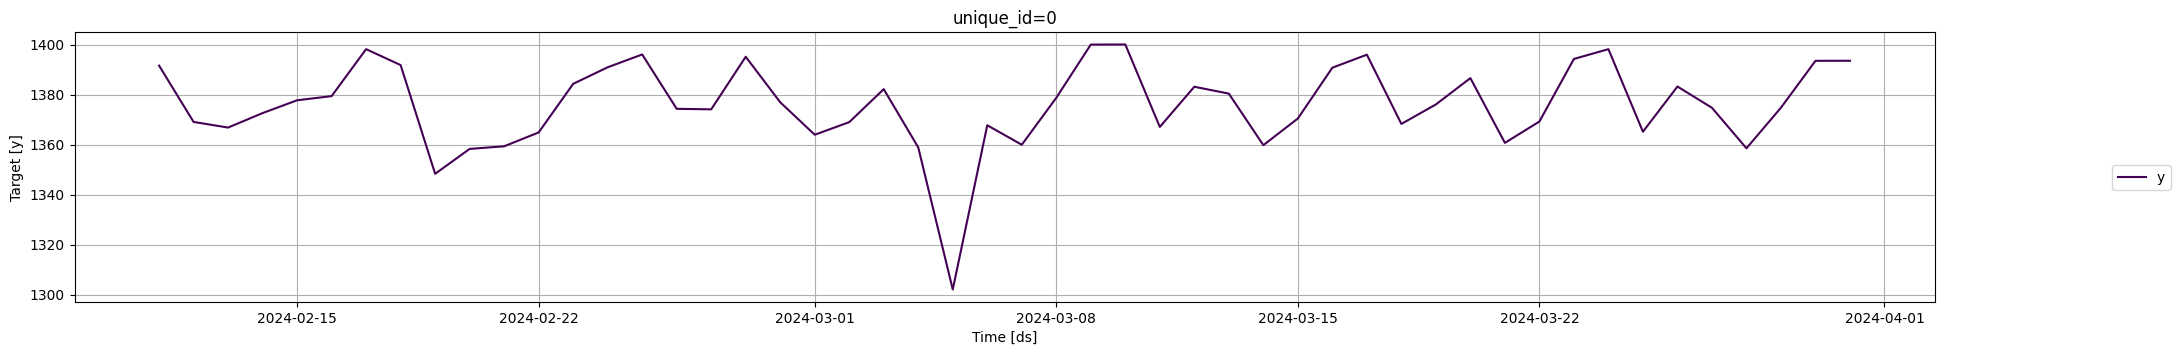

In [ ]:
fig = plot_series(df_test)
fig

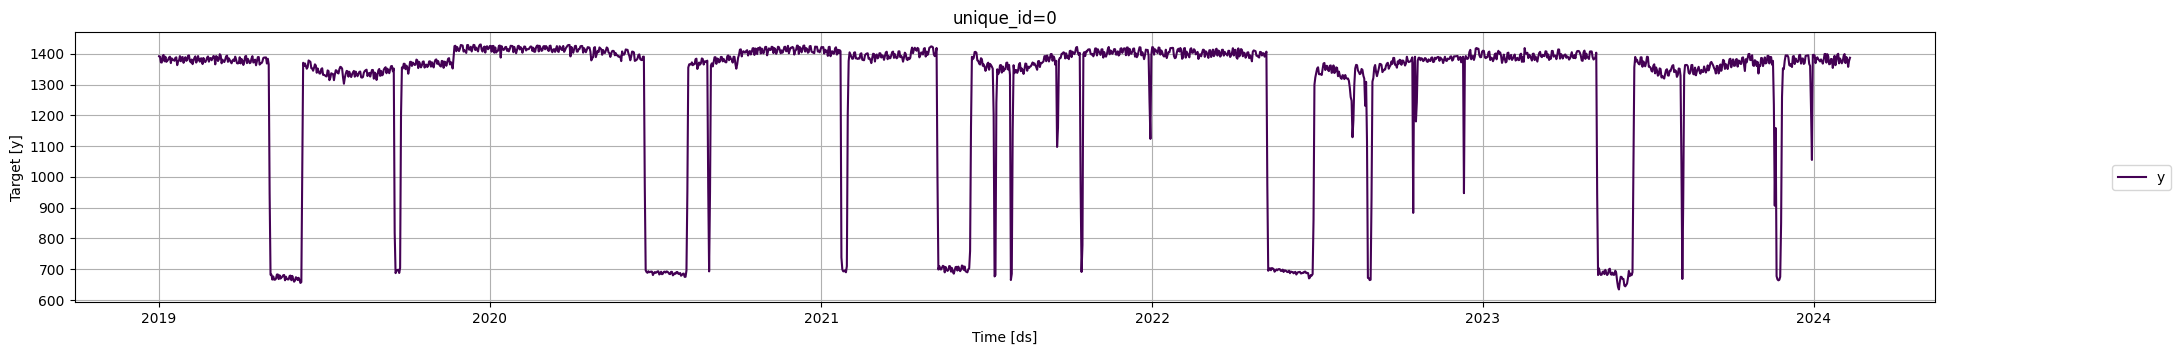

In [ ]:
fig = plot_series(df_train)
fig

In [ ]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

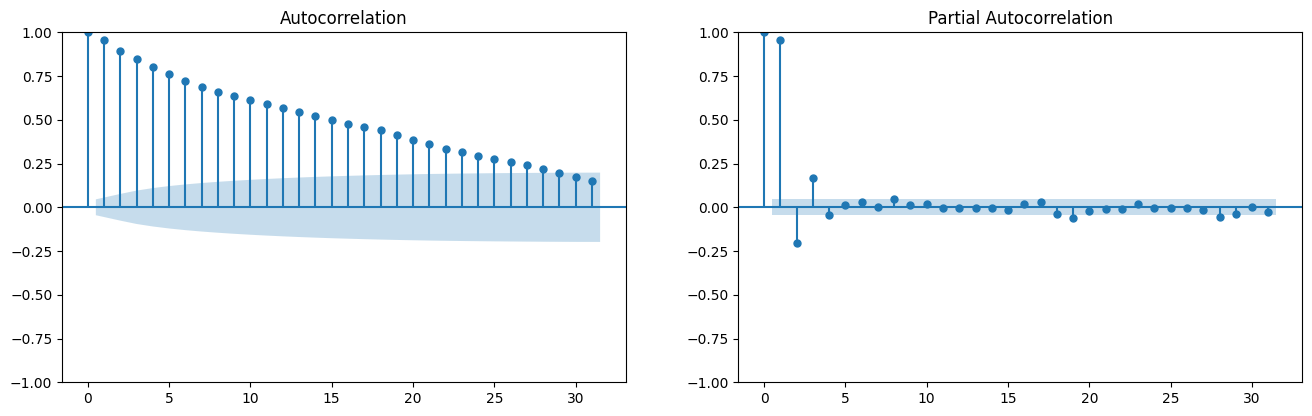

In [ ]:
acf_pacf(df_train['y'], 31)

In [ ]:
def teste_estacionaria(serie):
  p_value = adfuller(serie)[1]

  print(p_value)

  if p_value < 0.05:
    print("Série estacionaria")

  else:
    print("Série não estacionaria")

teste_estacionaria(df_test['y'])

8.62378147058416e-06
Série estacionaria


In [ ]:
from sklearn.base import BaseEstimator

In [ ]:
class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

In [ ]:
models = [
    Naive(),
    LinearRegression(),
    MLPRegressor(),
    KNeighborsRegressor(),
    XGBRegressor(),
]

### Criando o modelo

In [ ]:
from mlforecast.forecast import MLForecast
from mlforecast.lag_transforms import ExponentiallyWeightedMean, RollingMean
from mlforecast.target_transforms import Differences, LocalMinMaxScaler

In [ ]:
def is_monday(dates):
    return dates.dayofweek == 0

fcst = MLForecast(
    models=models,
    freq='D',
    lags=[x for x in range(1, 29)],
    date_features=['dayofweek', 'dayofyear', 'day', is_monday],
    target_transforms=[LocalMinMaxScaler(), Differences([0])]
)

In [ ]:
fcst.fit(df_train, id_col='unique_id', time_col='ds', target_col='y')

MLForecast(models=[Naive, LinearRegression, MLPRegressor, KNeighborsRegressor, XGBRegressor], freq=D, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 'lag21', 'lag22', 'lag23', 'lag24', 'lag25', 'lag26', 'lag27', 'lag28'], date_features=['dayofweek', 'dayofyear', 'day', <function is_monday at 0x7856e7ff7010>], num_threads=1)

In [ ]:
predict = fcst.predict(len(df_test))
predict

,unique_id,ds,Naive,LinearRegression,MLPRegressor,KNeighborsRegressor,XGBRegressor
0,0,2024-02-11,1386.916667,1374.367754,1356.985620,1398.108333,1356.967256
1,0,2024-02-12,1386.916667,1356.067279,1346.211129,1390.658333,1298.753924
2,0,2024-02-13,1386.916667,1354.234505,1346.294889,1389.875000,1027.408185
3,0,2024-02-14,1386.916667,1354.534557,1336.499826,1387.775000,1038.057661
4,0,2024-02-15,1386.916667,1350.845353,1332.782389,1392.233333,1065.775977
5,0,2024-02-16,1386.916667,1346.434517,1342.510228,1397.841667,1087.966233
6,0,2024-02-17,1386.916667,1342.725413,1357.346507,1393.858333,1108.399222
7,0,2024-02-18,1386.916667,1334.838907,1391.686422,1397.675000,1097.415187
8,0,2024-02-19,1386.916667,1320.064693,1319.036265,1392.875000,1085.236513
9,0,2024-02-20,1386.916667,1321.319407,1334.896748,1390.283333,1089.438200


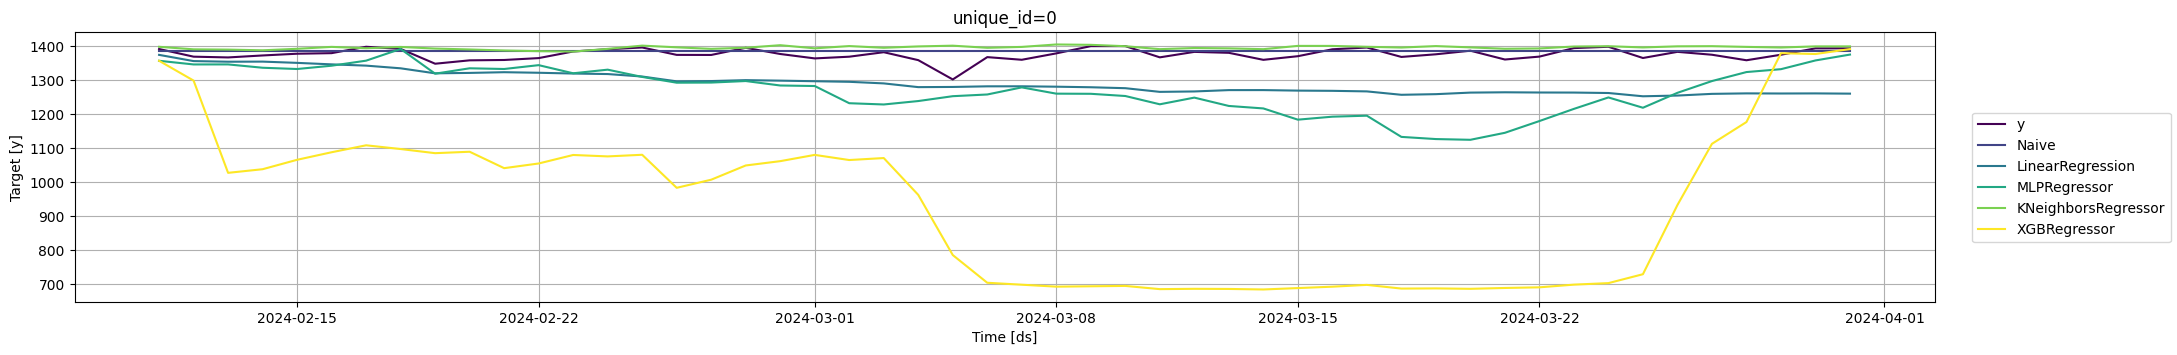

In [ ]:
plot_series(df_test, predict)

### Metricas dos modelos

In [ ]:
print("MAPE: ", MAPE(df_test['y'], predict['MLPRegressor']))
print("RMSE: ", np.sqrt(MSE(df_test['y'], predict['MLPRegressor'])))

MAPE:  0.0747845204942135
RMSE:  123.5329395213981


In [ ]:
print("MAPE: ", MAPE(df_test['y'], predict['LinearRegression']))
print("RMSE: ", np.sqrt(MSE(df_test['y'], predict['LinearRegression'])))

MAPE:  0.060801788370951806
RMSE:  91.63233773375259


In [ ]:
print("MAPE: ", MAPE(df_test['y'], predict['KNeighborsRegressor']))
print("RMSE: ", np.sqrt(MSE(df_test['y'], predict['KNeighborsRegressor'])))

MAPE:  0.014774739327468128
RMSE:  26.012910767872715


In [ ]:
print("MAPE: ", MAPE(df_test['y'], predict['XGBRegressor']))
print("RMSE: ", np.sqrt(MSE(df_test['y'], predict['XGBRegressor'])))

MAPE:  0.3184954672257898
RMSE:  492.097773295974


In [ ]:
print("MAPE: ", MAPE(df_test['y'], predict['Naive']))
print("RMSE: ", np.sqrt(MSE(df_test['y'], predict['Naive'])))

MAPE:  0.01138086554488073
RMSE:  20.3132226868031
